### Import Necessary Modules

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K
from keras import metrics as met

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAvgPool1D,MaxPooling1D
from keras.models import Model

from keras.layers import CuDNNLSTM, CuDNNGRU, SpatialDropout1D
from keras.layers import LeakyReLU
from keras.layers import GRU
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from keras.optimizers import Adadelta
from keras.optimizers import Adam

from keras.engine.topology import Layer

from sklearn.metrics import precision_recall_curve,auc,roc_curve
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import seaborn as sns


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


Using TensorFlow backend.


### Load Pre-processed Datasets (see text_preprocess.ipynb for details)

In [3]:
test_transformed      = pd.read_csv('test_transformed_full.csv')
train_transformed     = pd.read_csv('train_transformed_full.csv')
train_val_transformed = pd.read_csv('train_val_transformed_full.csv')


In [4]:
train_transformed.transformed=train_transformed.transformed.fillna(' ')
train_val_transformed.transformed=train_val_transformed.transformed.fillna(' ')
test_transformed.transformed=test_transformed.transformed.fillna(' ')

In [5]:
#tokenizer = Tokenizer(num_words=None,lower=False)
#tokenizer.fit_on_texts(train_transformed.transformed)

In [6]:
y_idhate = train_transformed["identity_hate"].values

In [7]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
list_classes_abr = ["toxic", "severe_toxic", "obscene", "insult", "identity_hate"]

#y = train_transformed[list_classes_abr].values
y = train_transformed[list_classes].values
y_threat = train_transformed["threat"].values

list_sentences_train = train_transformed["transformed"]

list_sentences_train_val = train_val_transformed["transformed"]

list_sentences_test = test_transformed["transformed"]

max_features = 20000

tokenizer = Tokenizer(num_words=None)

#Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 
tokenizer.fit_on_texts(list(list_sentences_train)) 

#ransforms each text in texts to a sequence of integers. Takes each word in the text and replaces it with its corresponding integer value from fit_on_texts
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

list_tokenized_train_val = tokenizer.texts_to_sequences(list_sentences_train_val)

list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

maxlen = 200

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

X_tval = pad_sequences(list_tokenized_train_val, maxlen=maxlen)

X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


inp = Input(shape=(maxlen, ))


#embed_size = 300
#x = Embedding(max_features, embed_size)(inp)



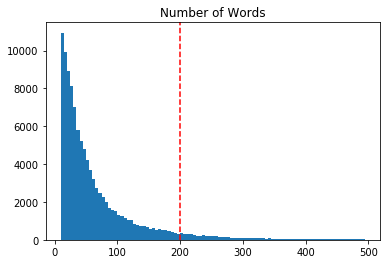

In [8]:
fig=plt.hist(totalNumWords,bins = np.arange(10,500,5))
plt.title('Number of Words')
plt.axvline(200, color='r', linestyle='--')

## Countplots show heavy class imbalance


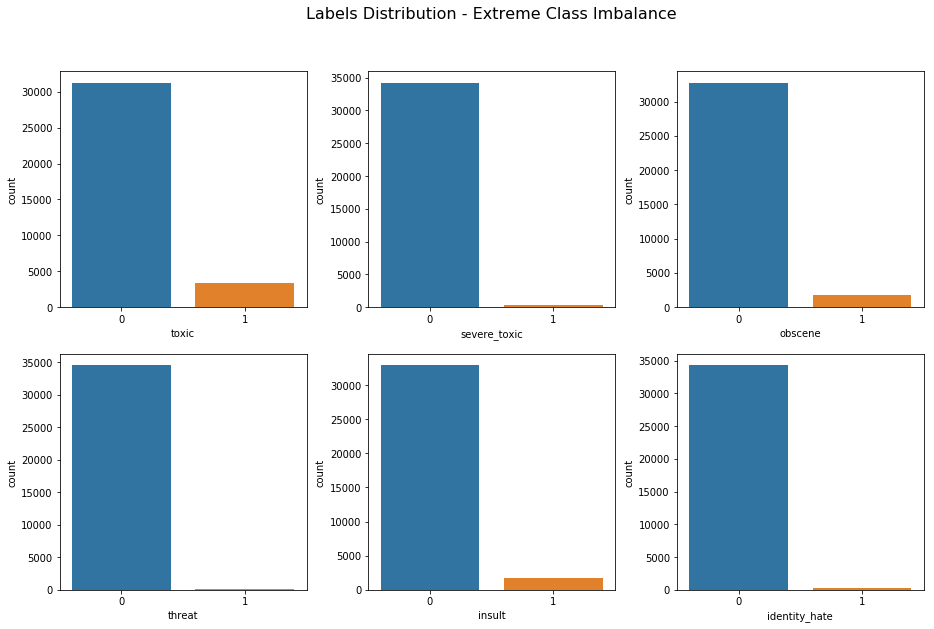

In [9]:
# The amount of space above titles
fig, ax = plt.subplots(figsize=(15,9), ncols=3, nrows=2)

left   =  0.1  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  0.25     # the amount of width reserved for blank space between subplots
hspace =  0.2    # the amount of height reserved for white space between subplots


# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)


y_title_margin = 0.2

plt.suptitle("Labels Distribution - Extreme Class Imbalance", y = 1.0, fontsize=16)

sns.countplot(train_val_transformed[list_classes[0]],    ax=ax[0][0])
sns.countplot(train_val_transformed[list_classes[1]],    ax=ax[0][1])
sns.countplot(train_val_transformed[list_classes[2]],    ax=ax[0][2])
sns.countplot(train_val_transformed[list_classes[3]],    ax=ax[1][0])
sns.countplot(train_val_transformed[list_classes[4]],    ax=ax[1][1])
sns.countplot(train_val_transformed[list_classes[5]],    ax=ax[1][2])


### Metric Functions for NN that are not provided with Keras

In [10]:
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall1 = true_positives / (possible_positives + K.epsilon())
        return recall1

def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    

def f1(y_true, y_pred):
    
    
    #precision1 = precision(y_true, y_pred)
    #recall1 = recall(y_true, y_pred)
    f1=2*((precision(y_true, y_pred)*recall(y_true, y_pred))/(precision(y_true, y_pred)\
                                                              +recall(y_true, y_pred)+K.epsilon()))
    return f1
    
from sklearn.metrics import roc_auc_score
#roc=roc_auc_score()


def auc(y_true, y_pred,average=None):
    K.get_session().run(K.local_variables_initializer())
    auc = roc_auc_score(y_true, y_pred)
    
    return auc
#model.compile(loss='binary_crossentropy',
#          optimizer= "adam",
#          metrics=[f1])

### ROC callback function

In [11]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            

## Attention Function

In [12]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

### Score Functions For Multi Labels

In [1]:
def rocs(val,pred):
    
    """ Returns roc_auc score for each label column"""
    
    n= predictions.shape[1]
    
    a=[roc_auc_score(val[:,n],pred[:,n]) for n in range(6)]
    
    return a



from sklearn.metrics import auc as auc1

def predrec(val,pred):
    
    """ Returns precision_recall auc score for each label column"""
    
    n= pred.shape[1]
    
    a=[precision_recall_curve(val[:,n],pred[:,n]) for n in range(6)]
    
    b=[auc1(element[1],element[0]) for element in a]
    
    
    return b

def predrecplot(val,pred):

    """ Plots precision_recall curve for each label column"""
    
    a=[precision_recall_curve(val[:,n],pred[:,n]) for n in range(6)]
    
    from inspect import signature
    
    from sklearn.metrics import average_precision_score
    
    for element in a:
       
        recall1=element[1]
        precision1=element[0]
        
        #average_precision = average_precision_score(y_val[:,3],predictions_threat)

        # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall1, precision1, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall1, precision1, alpha=0.1, color='b', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])

def rocplot(val,pred):

    """ Plots roc curve for each label column"""
    
    a=[roc_curve(val[:,n],pred[:,n]) for n in range(6)]
    
    from inspect import signature
    
    from sklearn.metrics import average_precision_score
    
    plt.plot([0, 1], [0.0, 1.0], linestyle='--',color='r',)   
        
    for element in a:
       
        ax1=element[0]
        ax2=element[1]
        
        rocscore = roc_auc_score(y_val,pred)

        # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(ax1, ax2, color='b', alpha=0.02,
                 where='post')
        plt.fill_between(ax1, ax2, alpha=0.1, color='b', **step_kwargs)

       # plt.xlabel('Recall')
       # plt.ylabel('Precision')
        plt.ylim([0.4, 1.05])
        plt.xlim([0.0, 0.8])
        plt.title('ROC Curve: Area={0:0.2f}'.format(
                  rocscore))


In [14]:
import gc
gc.collect()

35

In [15]:
y_toxic=y[:,0]
y_severe=y[:,1]
y_obscene=y[:,2]
y_threat=y[:,3]
y_insult=y[:,4]
y_idhate=y[:,5]

In [16]:
y_val=train_val_transformed.iloc[:,3:9].values

In [17]:
X_t.size

25000000

### Oversampling 

In [18]:
""" Oversampling for threat label class. What smote does is simple. First it finds the n-nearest neighbors in the minority
class for each of the samples in the class. Then it draws a line between the the neighbors an generates random points
on the lines and adds a random small values to the points to increase variance in them."""

# First we count the prevalent class, and base our oversampling model on this number
count=train_transformed[train_transformed['threat']==0].count()[0] 
count*0.01

#ADASYN model with class ratio dict 
sm = ADASYN(ratio={1: int(count*0.19), 0:int(count*1)},random_state=7)

X_t_sm, y_sm = sm.fit_sample(X_t, y_threat)

# Resultant dataset changes in size
y_sm.shape
X_t_sm.shape

(148284, 200)

In [19]:
#ADASYN model for identity hate

count=train_transformed[train_transformed['identity_hate']==0].count()[0]
count*0.01

sm = ADASYN(ratio={1: int(count*0.19), 0:int(count*1)},random_state=7)
#sm = RandomOverSampler(random_state=7)
X_t_id, y_id = sm.fit_sample(X_t, y_idhate)
#y_sm.shape
#X_t_sm.shape

### Class weights

In [20]:
"""Even though we are using sythetic oversampling, the each label is still imbalanced so we use class weights"""

from sklearn.utils import class_weight
class_weight = [class_weight.compute_class_weight('balanced',np.unique(y[:,n]),y[:,n]) for n in range(6)]

## Base Model - BiDirectional LSTMx2 and Attention Layer

In [21]:
optimizer =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

leaky = LeakyReLU(alpha=0.3)  # Use leaky activation to prevent dead nodes.

act=leaky

embed_size = 300

x = Embedding(max_features, embed_size)(inp)
#x = Reshape((embed_size, ))
x = Bidirectional(CuDNNLSTM(70, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2
#x = GRU(200, dropout=0.2,recurrent_dropout=0.2)(x)
x = SpatialDropout1D(rate=0.65)(x)

x = Bidirectional(CuDNNLSTM(70, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.65)(x)

#x = MaxPooling1D()(x)

x = AttentionWithContext()(x)

#x = Dropout(rate=0.65)(x)

x = Dense(70, activation=act)(x) #leaky
x = Dropout(rate=0.55)(x)

x = Dense(70, activation=act)(x) #leaky
x = Dropout(rate=0.55)(x)

x = Dense(70, activation=act)(x)#leaky
x = Dropout(rate=0.45)(x)

x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])
                 

batch_size = 32
epochs = 12

early_stop = EarlyStopping(patience=2,monitor='val_f1',mode='auto')

RocAuc = RocAucEvaluation(validation_data=(X_tval, y_val), interval=1)


model.fit(X_t,y, batch_size=batch_size, epochs=epochs,callbacks=[RocAuc,early_stop],\
           validation_split=0.2, class_weight=class_weight,shuffle=True)#[early_stop]


### Save model weights

In [22]:
# Saving model weights
model.save_weights('6_node_out')

In [25]:
x = Embedding(max_features, embed_size)(inp)
#x = Reshape((embed_size, ))
x = Bidirectional(CuDNNLSTM(70, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2
#x = GRU(200, dropout=0.2,recurrent_dropout=0.2)(x)
x = SpatialDropout1D(rate=0.65)(x)

x = Bidirectional(CuDNNLSTM(70, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.65)(x)


x = AttentionWithContext()(x)


x = Dense(70, activation=act)(x) #leaky
x = Dropout(rate=0.55)(x)

x = Dense(70, activation=act)(x) #leaky
x = Dropout(rate=0.55)(x)

x = Dense(70, activation=act)(x)#leaky
x = Dropout(rate=0.45)(x)

x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])


#loading model weights
model.load_weights('6_node_out')


C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


## Scoring

In [26]:
predictions=model.predict(X_tval)

In [27]:
roc_auc_score(y_val,predictions)

0.9701782794080493

In [28]:
p1,r1,_=precision_recall_curve(y_val[:,0],predictions[:,0])

In [29]:
auc1(r1,p1)

0.8586425940604376

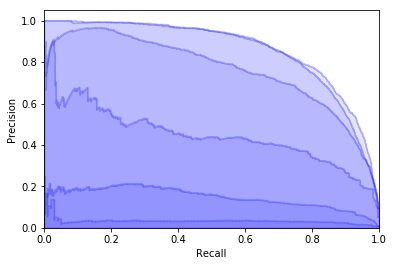

In [30]:
predrecplot(y_val,predictions)  #eskisi

In [31]:
predrec(y_val,predictions)

[0.8586425940604376,
 0.4453679002156927,
 0.8676066061150463,
 0.03188411126399454,
 0.7622833302600157,
 0.14787654359552482]

In [33]:
y_toxic=y[:,0]
y_severe=y[:,1]
y_obscene=y[:,2]
y_threat
y_insult=y[:,4]
y_idhate

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

## Remodeling Id Hate with Oversampling

In [34]:
###Best ID hate



from sklearn.utils import class_weight
#class_weight4 = class_weight.compute_class_weight('balanced',np.unique(toxic4),toxic4)
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_id),y_id)
class_weight



optimizer =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

leaky = LeakyReLU(alpha=0.3)  # Use leaky activation to prevent dead nodes.

act=leaky

embed_size = 300

x = Embedding(max_features, embed_size)(inp)
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be
# no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.


x = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.50)(x)

#x = MaxPooling1D()(x)

x = AttentionWithContext()(x)

#x = Dropout(rate=0.55)(x)

x = Dense(50, activation=act)(x) #leaky
x = Dropout(rate=0.45)(x)

x = Dense(50, activation=leaky)(x)#leaky
x = Dropout(rate=0.45)(x)

x = Dense(1, activation="sigmoid")(x)

model_id = Model(inputs=inp, outputs=x)
model_id.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])
                 

batch_size = 32
epochs = 5

early_stop = EarlyStopping(patience=2,monitor='val_f1',mode='auto')

RocAuc = RocAucEvaluation(validation_data=(X_tval, y_val), interval=1)

model_id.fit(X_t_id,y_id, batch_size=batch_size, epochs=epochs,callbacks=None,\
           validation_split=0.2, class_weight=class_weight)#[early_stop]


In [35]:
model_id.save_weights("model_id.h5")

In [36]:
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.50)(x)

x = AttentionWithContext()(x)

x = Dense(50, activation=act)(x) #leaky

x = Dropout(rate=0.45)(x)

x = Dense(50, activation=leaky)(x)#leaky

x = Dropout(rate=0.45)(x)

x = Dense(1, activation="sigmoid")(x)

model_id = Model(inputs=inp, outputs=x)
model_id.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])
model_id.load_weights("model_id.h5")

C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


### Id Hate Scoring

In [37]:
predictions_id=model_id.predict(X_tval)

In [38]:
predictions_id

array([[0.0000000e+00],
       [1.1331439e-03],
       [1.1920929e-07],
       ...,
       [5.9237937e-10],
       [3.0971678e-10],
       [2.7416958e-09]], dtype=float32)

In [39]:
roc_auc_score(y_val[:,5],predictions[:,5])

0.954038023531103

In [40]:
roc_auc_score(y_val[:,5],predictions_id)

0.9535308334718485

In [41]:
p1,r1,_=precision_recall_curve(y_val[:,5],predictions[:,5])
auc1(r1,p1)

0.14787654359552482

In [42]:
p1,r1,_=precision_recall_curve(y_val[:,5],predictions_id)
auc1(r1,p1)

0.3913515943851751

In [43]:
predictions2=np.append(predictions[:,:5],predictions_id,1)

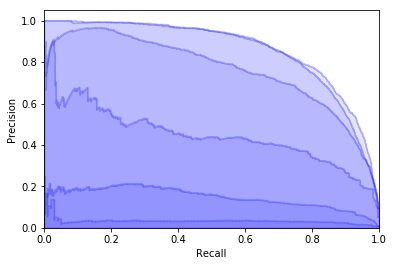

In [44]:
predrecplot(y_val,predictions)

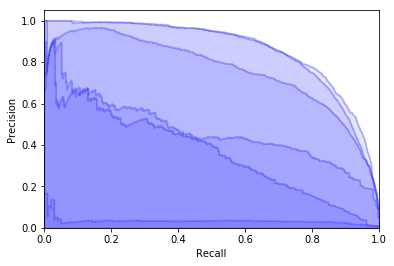

In [45]:
predrecplot(y_val,predictions2)

In [46]:
predrec(y_val,predictions)

[0.8586425940604376,
 0.4453679002156927,
 0.8676066061150463,
 0.03188411126399454,
 0.7622833302600157,
 0.14787654359552482]

In [47]:
predrec(y_val,predictions2)

[0.8586425940604376,
 0.4453679002156927,
 0.8676066061150463,
 0.03188411126399454,
 0.7622833302600157,
 0.3913515943851751]

In [48]:
rocs(y_val,predictions)

[0.9690219543177313,
 0.9898882347342752,
 0.9842923591419752,
 0.9444680752816315,
 0.97936102944158,
 0.954038023531103]

In [49]:
rocs(y_val,predictions2)

[0.9690219543177313,
 0.9898882347342752,
 0.9842923591419752,
 0.9444680752816315,
 0.97936102944158,
 0.9535308334718485]

### Remodeling Threat with Oversampling

In [50]:
count=train_transformed[train_transformed['threat']==0].count()[0]
count*0.01

sm = ADASYN(ratio={1: int(count*0.19), 0:int(count*1)},random_state=7)

X_t_thr, y_thr = sm.fit_sample(X_t, y_threat)


In [51]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_thr),y_thr)

optimizer =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

leaky = LeakyReLU(alpha=0.3)  # Use leaky activation to prevent dead nodes.

act=leaky

embed_size = 300

x = Embedding(max_features, embed_size)(inp)
#x = Reshape((embed_size, ))
x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2
#x = GRU(200, dropout=0.2,recurrent_dropout=0.2)(x)
x = SpatialDropout1D(rate=0.3)(x)

x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.3)(x)

#x = MaxPooling1D()(x)

x = AttentionWithContext()(x)

x = Dropout(rate=0.5)(x)

x = Dense(80, activation=act)(x) #leaky
x = Dropout(rate=0.25)(x)

x = Dense(80, activation=act)(x)#leaky
x = Dropout(rate=0.10)(x)

x = Dense(1, activation="sigmoid")(x)

model_thr = Model(inputs=inp, outputs=x)
model_thr.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])
                 

batch_size = 256
epochs = 21

early_stop = EarlyStopping(patience=5,monitor='val_recall')

model_thr.fit(X_t_sm,y_sm, batch_size=batch_size, epochs=epochs,callbacks=None,\
           validation_split=0.2,shuffle=True)#[early_stop]


In [52]:
model_thr.save_weights('model_thr.h5')

### Scoring Threat

In [54]:
x = Embedding(max_features, embed_size)(inp)
#x = Reshape((embed_size, ))
x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2
#x = GRU(200, dropout=0.2,recurrent_dropout=0.2)(x)
x = SpatialDropout1D(rate=0.3)(x)

x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)#,dropout=0.2,recurrent_dropout=0.2

x = SpatialDropout1D(rate=0.3)(x)

#x = MaxPooling1D()(x)

x = AttentionWithContext()(x)

x = Dropout(rate=0.5)(x)

x = Dense(80, activation=act)(x) #leaky
x = Dropout(rate=0.25)(x)

x = Dense(80, activation=act)(x)#leaky
x = Dropout(rate=0.10)(x)

x = Dense(1, activation="sigmoid")(x)

model_thr = Model(inputs=inp, outputs=x)
model_thr.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',recall,precision,f1])
model_thr.load_weights('model_thr.h5')

C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\Aytu\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [55]:
predictions_thr=model_thr.predict(X_tval)

In [56]:
roc_auc_score(y_val[:,3],predictions[:,3])

0.9444680752816315

In [57]:
roc_auc_score(y_val[:,3],predictions_thr)

0.9562196560810383

In [58]:
# Score before oversampling

p1,r1,_=precision_recall_curve(y_val[:,3],predictions[:,3])
auc1(r1,p1)

0.03188411126399454

In [59]:
# Score after oversampling

p1,r1,_=precision_recall_curve(y_val[:,3],predictions_thr)
auc1(r1,p1)

0.4406256417829552

## Augmented Predictions

In [60]:
# this is  final augmented predictions
predictions3=np.append(np.append(predictions2[:,:3],predictions_thr,1),predictions2[:,4:],1)

In [63]:
predrec(y_val,predictions)

[0.8586425940604376,
 0.4453679002156927,
 0.8676066061150463,
 0.03188411126399454,
 0.7622833302600157,
 0.14787654359552482]

In [64]:
predrec(y_val,predictions3)

[0.8586425940604376,
 0.4453679002156927,
 0.8676066061150463,
 0.4406256417829552,
 0.7622833302600157,
 0.3913515943851751]

In [65]:
rocs(y_val,predictions3)

[0.9690219543177313,
 0.9898882347342752,
 0.9842923591419752,
 0.9562196560810383,
 0.97936102944158,
 0.9535308334718485]

In [66]:
roc_auc_score(y_val,predictions3)

0.9720523445314081

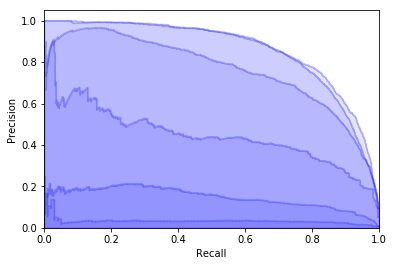

In [71]:
# Precision - recall plot for each label
predrecplot(y_val,predictions)

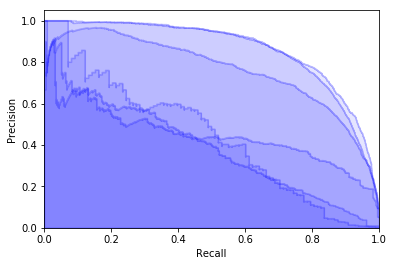

In [72]:
# Precision - recall plot for each label

predrecplot(y_val,predictions3)

In [73]:
np.mean(predrec(y_val,predictions))

0.5189435142517853

In [74]:
np.mean(predrec(y_val,predictions3))

0.6276462778032205

In [75]:
np.mean(rocs(y_val,predictions))

0.9701782794080493

In [76]:
np.mean(rocs(y_val,predictions3))

0.9720523445314081

In [77]:
roc_auc_score(y_val,predictions)

0.9701782794080493

In [78]:
roc_auc_score(y_val,predictions3,average='weighted')

0.9750951531583582

In [3]:
# Roc plot for each label
rocplot(y_val,predictions3)
plt.plot([0, 0.45],[0.4, 1], linestyle='--',color='r')

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val[:,0],np.round(predictions3[:,0]))

array([[30873,   401],
       [  972,  2325]], dtype=int64)

In [533]:
from sklearn.metrics import accuracy_score
accs=[accuracy_score(y_val[:,n],np.round(predictions3[:,n])) for n in range(6)]
np.mean(accs)

0.9813668489003308

In [527]:
roc_auc_score(y_val,(predictions3))

0.9720523445314081